In [1]:
import pymongo
import matplotlib.pyplot as plt
import pandas as pd
MongoClient = pymongo.MongoClient
client = MongoClient()
db = client.companies
import re
companies = db['companies']
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np


In [2]:
def convert_companies(company):
    return {
        'name': company['name'],
        'category_code': company['category_code'],
        'founded_year': company['founded_year'],
        'number_of_employees': company['number_of_employees'],
        'total_money_raised': company['total_money_raised'],
        'offices': company['offices']
               }

cursor = companies.find({"$and": [ { "offices.latitude": {"$exists": True} },{ "offices.longitude": {"$exists": True} }, { "founded_year": {"$gt": 2002} }, {"deadpooled_year": None}  ] },{"_id":0})
geoCompanies = list(map(lambda r: convert_companies(r), cursor))

In [3]:
def convert_offices(company):
    companies = []
    for x in geoCompanies:
        for y in x['offices']:
            z = {
            'name': x['name'],
            'category_code': x['category_code'],
            'founded_year': x['founded_year'],
            'number_of_employees': x['number_of_employees'],
            'total_money_raised': x['total_money_raised'],
            'city': y['city'],
            'description': y['description'],
            'country_code': y['country_code'],
            'latitude': y['latitude'],
            'longitude': y['longitude']}
            companies.append(z)
    return companies
offices = convert_offices(geoCompanies)

In [4]:
df = pd.DataFrame(offices)
df.head()


,category_code,city,country_code,description,founded_year,latitude,longitude,name,number_of_employees,total_money_raised
0,news,San Francisco,USA,None,2004,37.764726,-122.394523,Digg,60.0,$45M
1,web,West Hollywood,USA,Headquarters,2006,34.090368,-118.393064,Geni,18.0,$16.5M
2,web,Menlo Park,USA,None,2003,37.484130,-122.169472,Gizmoz,NaN,$18.1M
3,mobile,Los Angeles,USA,None,2005,34.057498,-118.446596,Helio,NaN,$0
4,music,San Diego,USA,,2006,33.022176,-117.081406,Slacker,NaN,$73.1M


In [5]:
df["local"] = df["name"] + df["description"]
df['local'].head()

0                 NaN
1    GeniHeadquarters
2                 NaN
3                 NaN
4             Slacker
Name: local, dtype: object

In [6]:
def posicion(x):
    position = []
    for i in range(len(df)):
        lat = df.iloc[i]["latitude"]
        lon = df.iloc[i]["longitude"]
        point = {"type":"Point", "coordinates": [lon,lat]}
        position.append(point)
    return position
df['position'] = posicion(df)


In [7]:
def moneylaundry(money):
    res = []
    for x in money:
        x = x.replace('$', '').replace('€', '').replace('£', '').replace('¥', '').replace('C', '').replace('kr', '')
        if 'M' in x:
            x = x.replace('M', '')
            res.append(float(x)*1000000)
        elif 'k' in x:
            x = x.replace('k', '')
            res.append(float(x)*1000)

        elif 'B' in x:
            x = x.replace('B', '')
            res.append(float(x)*1000000000)

        else:
            res.append(float(x))
    return res
df['total_money_raised'] = moneylaundry(df['total_money_raised'])
df.head()

,category_code,city,country_code,description,founded_year,latitude,longitude,name,number_of_employees,total_money_raised,local,position
0,news,San Francisco,USA,None,2004,37.764726,-122.394523,Digg,60.0,45000000.0,NaN,"{'type': 'Point', 'coordinates': [-122.394523,..."
1,web,West Hollywood,USA,Headquarters,2006,34.090368,-118.393064,Geni,18.0,16500000.0,GeniHeadquarters,"{'type': 'Point', 'coordinates': [-118.393064,..."
2,web,Menlo Park,USA,None,2003,37.484130,-122.169472,Gizmoz,NaN,18100000.0,NaN,"{'type': 'Point', 'coordinates': [-122.169472,..."
3,mobile,Los Angeles,USA,None,2005,34.057498,-118.446596,Helio,NaN,0.0,NaN,"{'type': 'Point', 'coordinates': [-118.446596,..."
4,music,San Diego,USA,,2006,33.022176,-117.081406,Slacker,NaN,73100000.0,Slacker,"{'type': 'Point', 'coordinates': [-117.081406,..."


In [8]:
df.dtypes

category_code           object
city                    object
country_code            object
description             object
founded_year             int64
latitude               float64
longitude              float64
name                    object
number_of_employees    float64
total_money_raised     float64
local                   object
position                object
dtype: object

In [9]:
df['category_code'].value_counts()

web                 1842
software            1334
advertising          672
games_video          585
mobile               546
enterprise           493
ecommerce            374
other                359
consulting           335
network_hosting      299
public_relations     244
search               212
cleantech            139
hardware             133
biotech              119
security              76
analytics             74
semiconductor         64
social                56
finance               46
news                  46
music                 43
messaging             36
education             29
photo_video           27
travel                25
health                16
transportation        14
medical               14
sports                10
manufacturing         10
real_estate            9
fashion                8
automotive             6
hospitality            5
design                 5
legal                  5
nanotech               2
nonprofit              2
Name: category_code, dtyp

In [10]:
def success(x):
    counter = 0
    if x == ('education' or 'public_relations'):
        counter += (-5)
    elif x == ('semiconductor' or 'music' or 'automotive'):
        counter += (-4)
    elif x == ('messaging' or 'fashion'):
        counter += (-3)
    elif x == ('nonprofit' or  'finance'):   
        counter += (-2)
    elif x == ('other'):
        counter += (-1)
    elif x == ('consulting' or 'search' or 'travel'):
        counter += (1)
    elif x == ('enterprise' or 'analytics' or 'nanotech' or 'design' or 'transportation'):
        counter += (2)
    elif x == ('social' or 'photo_video'):
        counter += (3)
    elif x == ('ecommerce' or 'biotech' or 'security'):   
        counter += (4)
    elif x == ('legal' or 'real_state'):
        counter += (5)
    elif x == ('web' or 'software' or 'network_hosting' or 'cleantech' or 'medical' or 'health' or 'manufacturing' or 'sports' or 'software'):
        counter += (6)
    elif x == ('advertising' or 'hardware'):
        counter += (7)
    elif x == ('hospitality' or 'news'):   
        counter += (8)
    elif x == ('mobile'):
        counter += (9)
    else:
        counter += (10)
    return counter
successpercentage = df['category_code'].map(success)

In [11]:
def power(x):
    budget = 0
    if x >= 800:
        budget += 6
    elif x >= 500 and x < 800:    
        budget += 4
    elif x >= 100 and x < 500:    
        budget += 2
    elif x >= 50 and x < 100:    
        budget -= 1
    else:    
        budget -= 3
    return budget

powermoves = df['number_of_employees'].map(power)

In [12]:
def statevalue(x):
    return x['category_code'].map(success) + x['number_of_employees'].map(power)

df['value'] = statevalue(df)

In [13]:
df['founded_year'].astype(np.float64)

0       2004.0
1       2006.0
2       2003.0
3       2005.0
4       2006.0
5       2007.0
6       2007.0
7       2006.0
8       2006.0
9       2004.0
10      2004.0
11      2004.0
12      2006.0
13      2007.0
14      2004.0
15      2006.0
16      2004.0
17      2004.0
18      2004.0
19      2004.0
20      2004.0
21      2004.0
22      2008.0
23      2008.0
24      2008.0
25      2008.0
26      2008.0
27      2005.0
28      2005.0
29      2006.0
         ...  
8381    2006.0
8382    2009.0
8383    2005.0
8384    2007.0
8385    2004.0
8386    2004.0
8387    2009.0
8388    2008.0
8389    2008.0
8390    2008.0
8391    2004.0
8392    2006.0
8393    2009.0
8394    2009.0
8395    2011.0
8396    2011.0
8397    2008.0
8398    2004.0
8399    2009.0
8400    2004.0
8401    2006.0
8402    2009.0
8403    2009.0
8404    2009.0
8405    2006.0
8406    2004.0
8407    2012.0
8408    2003.0
8409    2009.0
8410    2009.0
Name: founded_year, Length: 8411, dtype: float64

In [14]:
df['value'].astype(np.float64)

0        9.0
1        3.0
2        3.0
3        6.0
4        7.0
5        9.0
6        0.0
7        7.0
8        9.0
9        9.0
10       9.0
11       9.0
12       9.0
13       3.0
14       7.0
15       7.0
16       9.0
17       9.0
18       9.0
19       9.0
20       9.0
21       9.0
22       9.0
23       9.0
24       9.0
25       9.0
26       9.0
27       6.0
28      14.0
29       7.0
        ... 
8381     7.0
8382     7.0
8383     7.0
8384     7.0
8385    -2.0
8386    -2.0
8387     3.0
8388    -1.0
8389     7.0
8390    -4.0
8391     7.0
8392     3.0
8393     4.0
8394     7.0
8395    -6.0
8396    -6.0
8397     3.0
8398     4.0
8399     6.0
8400    -7.0
8401     7.0
8402    -2.0
8403    -2.0
8404     6.0
8405     3.0
8406     7.0
8407     3.0
8408     7.0
8409     7.0
8410     4.0
Name: value, Length: 8411, dtype: float64

In [15]:
df = df[['name','local','category_code','city','founded_year','number_of_employees','total_money_raised','latitude','longitude', 'value']]
df.head()

,name,local,category_code,city,founded_year,number_of_employees,total_money_raised,latitude,longitude,value
0,Digg,NaN,news,San Francisco,2004,60.0,45000000.0,37.764726,-122.394523,9
1,Geni,GeniHeadquarters,web,West Hollywood,2006,18.0,16500000.0,34.090368,-118.393064,3
2,Gizmoz,NaN,web,Menlo Park,2003,NaN,18100000.0,37.484130,-122.169472,3
3,Helio,NaN,mobile,Los Angeles,2005,NaN,0.0,34.057498,-118.446596,6
4,Slacker,Slacker,music,San Diego,2006,NaN,73100000.0,33.022176,-117.081406,7


In [16]:
df.to_json('comp_with_coords.json', orient='records', lines= True)

In [17]:
df_pos = df[['latitude', 'longitude']]
data1 = df_pos.values

In [ ]:
cursor = []
for x in range(len(df)):
    lat = df.latitude.iloc[x]
    lgtd = df.longitude.iloc[x]
    cursor.append(list(db.clean.find({"position": 
                     {"$near": 
                      {"$geometry": {"type": "Point", 
                                     "coordinates": [lgtd, lat]},
                       "$maxDistance": 8000}}})))
    
count = [len(e) for e in cursor]
df["count"] = count

In [ ]:
softcp_areas = df[df["count"] >= 50]

In [ ]:
softcp_areas[softcp_areas["name"] == "Wisevid_office_1"]

In [ ]:
softcp_areas = softcp_areas.drop(columns=['founded_year','number_of_employees','total_money_raised','position','count'])
softcp_areas = softcp_areas.drop_duplicates()

In [ ]:
softcp_areas.to_json('visualize_companies2.json', orient="records", lines = True)

NameError: name 'color' is not defined

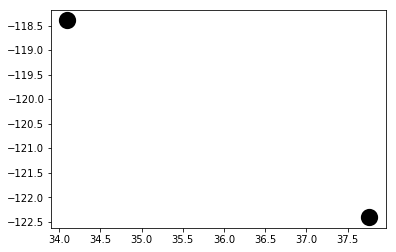

In [21]:
class K_Means:
    
    def __init__(self, k=2, tol= 0.001, max_iter=300):
        self.k = k
        self.tol = tol
        self.max_iter = max_iter
        
    def fit(self,data):
        self.centroids = {}
        
        for i in range(self.k):
            self.centroids[i] = data[i]
        
        for i in range(self.max_iter):
            self.classifications = {}
            
            for i in range (self.k):
                self.classifications[i] = []
                
            for featureset in data:
                distances = [np.linalg.norm(featureset-self.centroids[centroid]) for centroid in self.centroids]
                classification = distances.index(min(distances))
                self.classifications[classification].append(featureset)
            
            prev_centroids = dict(self.centroids)
            
            for classification in self.classifications:
                pass
                #self.centroids[classification] = np.average(self.classifications[classification], axis=0)
            
            optimized = True
            
            for c in self.centroids:
                original_centroid = prev_centroids[c]
                current_centroid = self.centroids[c]
                if np.sum((current_centroid-original_centroid)/original_centroid*100.0) > self.tol:
                    optimized = False
            
            if optimized:
                break
                
    def predict(self,data):
        distances = [np.linalg.norm(data-self.centroids[centroid]) for centroid in self.centroids]
        classification = distances.index(min(distances))
        return classification

clf = K_Means()
clf.fit(data1)
    
for centroid in clf.centroids:
        plt.scatter(clf.centroids[centroid][0], clf.centroids[centroid][1], marker = 'o', color='k', s=150, linewidths=5)
                
for classification in clf.classifications:
        color = colors[classification]
        for featureset in clf.classifications[classification]:
            plt.scatter(featureset[0], featureset[1], marker='x', color = color, s=150, linewidths=5)
            
plt.show()   
    